In [ ]:
# cards.py
from typing import Tuple

# Simple color codes for readability
RED, YELLOW, GREEN, BLUE = 'R', 'Y', 'G', 'B'

# Card is a tuple: (color_code, number 0-9)
Card = Tuple[str, int]

In [ ]:
# pomdp.py:
from typing import List, Tuple, Optional
# from cards import Card

# State type: S = (H_1, H_2, D_g, P, P_t, G_o)
State = Tuple[List[Card], List[Card], List[Card], List[Card], Optional[Card], str]


# Action type: A = {X_1} ∪ {Y_n : n ∈ {1, 2, 4}}
class Action:
    """
    Action space for UNO game.
    A = {X_1}, {Y_n : n ∈ {1, 2, 4}}

    An action is EITHER:
    - X_1: a single card to play from hand
    - Y_n: draw n cards from deck where n ∈ {1, 2, 4}
    """

    def __init__(self, X_1: Optional[Card] = None, n: Optional[int] = None):
        """
        Initialize an action - must specify EITHER X_1 OR n, not both.

        Args:
            X_1: Card to play (COLOR, VALUE) - for PLAY action
            n: Number of cards to draw, n ∈ {1, 2, 4} - for DRAW action
        """
        # Validate that exactly one is specified
        if (X_1 is None and n is None) or (X_1 is not None and n is not None):
            raise ValueError("Must specify EITHER X_1 (play) OR n (draw), not both or neither")

        self.X_1 = X_1  # Card to play (None if draw action)
        self.n = n      # Number to draw (None if play action)
        self.Y_n = []   # Cards actually drawn (filled during execution)

        # Validation for draw action
        if n is not None and n not in [1, 2, 4]:
            raise ValueError(f"n must be in {{1, 2, 4}}, got {n}")

    def is_play(self) -> bool:
        """Returns True if this is a PLAY action (X_1)"""
        return self.X_1 is not None

    def is_draw(self) -> bool:
        """Returns True if this is a DRAW action (Y_n)"""
        return self.n is not None

    def __repr__(self):
        if self.is_play():
            return f"Action(X_1={self.X_1})"
        elif self.is_draw():
            if len(self.Y_n) > 0:
                return f"Action(Y_{self.n}={self.Y_n})"
            else:
                return f"Action(Y_{self.n}=[])"

In [ ]:
# uno.py

import random
from typing import List
from collections import Counter
from math import comb
# from cards import RED, YELLOW, GREEN, BLUE, Card
# from pomdp import State, Action

class Uno:
    """
    Simplified UNO initialization with only number cards (no specials).
    D = H_1 ⊔ H_2 ⊔ D_g ⊔ P : entire deck partitioned into hands, draw pile, played pile.
    Builds 76-card deck: 4 colors, (1 zero + 2 each of 1-9).
    """
    def __init__(self, H_1: List[Card] = None, H_2: List[Card] = None, D_g: List[Card] = None, P: List[Card] = None):
        self.H_1 = H_1 if H_1 is not None else [] # Player 1 hand
        self.H_2 = H_2 if H_2 is not None else [] # Player 2 hand
        self.D_g = D_g if D_g is not None else [] # Current draw deck (as list for drawing)
        self.P = P if P is not None else [] # Played cards (top card at end)
        self.G_o = "Active" # Game status: "Active" or "GameOver"
        self.State = None
        self.P_t = None

    def build_number_deck(self) -> List[Card]:
        """
        Builds the full number-only deck.
        - One 0 per color.
        - Two each of 1 through 9 per color.
        Returns list of 76 cards.
        """
        deck: List[Card] = []
        colors = [RED, YELLOW, GREEN, BLUE]
        for color in colors:
            # Add the single 0 for this color
            deck.append((color, 0))
            # Add two of each number 1-9 for this color
            for number in range(1, 10):
                deck.append((color, number))
                deck.append((color, number))
        return deck

    def new_game(self, seed: int = None, deal: int = 7):
        """
        Initializes a new game state on this instance.
        - Shuffles the full number deck.
        - Deals 'deal' cards to H_1 and H_2.
        - D_g gets the remainder.
        - P starts with the first card from D_g (top card).
        """
        rng = random.Random(seed)
        full_deck = self.build_number_deck()
        rng.shuffle(full_deck)

        # Deal to hands
        self.H_1 = full_deck[:deal]
        self.H_2 = full_deck[deal:2 * deal]
        remaining = full_deck[2 * deal:]

        # Start played pile with top of remaining (pop from front)
        self.P = [remaining.pop(0)]
        self.D_g = remaining
        self.G_o = "Active"

        self.create_S()

    def create_S(self) -> State:
        """
        Creates the system state S as seen by "God".
        S = (H_1, H_2, D_g, P, P_t, G_o)
        - H_1: Player 1 hand (list)
        - H_2: Player 2 hand (list)
        - D_g: Current deck (list)
        - P: Played cards pile (list)
        - P_t: Top card of pile (COLOR, VALUE) or None if empty
        - G_o: Game status ("Active" or "GameOver")
        """
        # Get top card P_t (last card in pile, or None if empty)
        self.P_t = self.P[-1] if len(self.P) > 0 else None

        self.State = (self.H_1, self.H_2, self.D_g, self.P, self.P_t, self.G_o)
        return self.State

    def update_S(self):
        """
        Updates the system state.
        Any parameter that is None will not be updated.
        """
        # Check game over condition: if either hand is empty
        if len(self.H_1) == 0 or len(self.H_2) == 0:
            self.G_o = "GameOver"
        self.create_S()  # Recompute P_t and State with updated G_o


    def print_S(self):
        if self.State is None:
            self.create_S()
        print(f"H_1: {self.State[0]}, {len(self.State[0])} cards")
        print(f"H_2: {self.State[1]}, {len(self.State[1])} cards")
        print(f"D_g: {self.State[2]}, {len(self.State[2])} cards")
        print(f"P: {self.State[3]}, {len(self.State[3])} cards")
        print(f"P_t: {self.State[4]}")
        print(f"G_o: {self.State[5]}")

    def is_legal_play(self, card: Card) -> bool:
        """
        Checks if a card can be legally played on top of P_t.
        Legal if: card color matches P_t color OR card value matches P_t value

        Args:
            card: Card to check (COLOR, VALUE)

        Returns:
            True if card is legal to play, False otherwise
        """
        if self.P_t is None:
            return False

        P_t_color, P_t_value = self.P_t
        card_color, card_value = card

        return card_color == P_t_color or card_value == P_t_value

    def get_legal_actions(self, player: int = 1) -> List[Action]:
        """
        Returns list of legal actions for specified player.

        Args:
            player: 1 for H_1, 2 for H_2

        Returns:
            List of legal Action objects
        """
        if self.State is None:
            self.create_S()
        legal_actions = []
        hand = self.H_1 if player == 1 else self.H_2

        if self.P_t is None:
            return legal_actions

        # Check which cards in hand can be played
        for card in hand:
            if self.is_legal_play(card):
                legal_actions.append(Action(X_1=card))

        # If no legal plays, must draw 1 card
        if len(legal_actions) == 0:
            legal_actions.append(Action(n=1))

        return legal_actions

    def execute_action(self, action: Action, player: int = 1) -> bool:
        """
        Executes an action and updates the game state.

        Args:
            action: Action to execute (either X_1 play or Y_n draw)
            player: 1 for H_1, 2 for H_2

        Returns:
            True if action was successful, False otherwise
        """
        if self.G_o == "GameOver":
            print("Game is over, no actions allowed")
            return False

        # Select the correct hand
        hand = self.H_1 if player == 1 else self.H_2

        if action.is_play():
            # Play card X_1
            if action.X_1 not in hand:
                print(f"Card {action.X_1} not in player {player}'s hand")
                return False

            if not self.is_legal_play(action.X_1):
                print(f"Card {action.X_1} is not a legal play on {self.P_t}")
                return False

            # Remove from hand and add to pile
            hand.remove(action.X_1)
            self.P.append(action.X_1)
        elif action.is_draw():
            # Draw n cards
            n = action.n
            cards_drawn = []

            for i in range(n):
                if len(self.D_g) == 0:
                    # Reshuffle played pile into new deck (keep top card P_t), taking all cards except the top card (P_t)
                    cards_to_shuffle = self.P[:-1]
                    self.P = [self.P[-1]]  # Keep only top card

                    # Shuffle and make new deck
                    random.shuffle(cards_to_shuffle)
                    self.D_g = cards_to_shuffle
                    print(f"Deck empty - reshuffled {len(self.D_g)} cards from pile")

                # Draw from end of deck (top)
                card = self.D_g.pop()
                cards_drawn.append(card)
                hand.append(card)

            action.Y_n = cards_drawn

        # Update state
        self.update_S()
        return True

    def get_O_space(self):
        """
        O = (H_1, |H_2|, |D_g|, P, P_t, G_o) - observation (as seen by “Player 1”)
        """
        if self.State is None:
            self.create_S()
        self.O = (self.H_1, len(self.H_2), len(self.D_g), self.P, self.P_t, self.G_o)
        return self.O

    def T(self, s_prime: State, action: Action, player: int = 1) -> float:
        """
        Transition probability function T(s' | s, a).

        Given current state s (self), action a, and next state s_prime,
        returns the probability of transitioning to s_prime.

        Args:
            s_prime: Next state (H_1', H_2', D_g', P', P_t', G_o')
            action: Action taken (X_1 or Y_n)
            player: Which player (1 or 2)

        Returns:
            Probability in [0, 1]
        """
        if self.State is None:
            self.create_S()

        # Unpack current state from self
        H_1, H_2, D_g, P, P_t, G_o = self.State

        # Unpack next state
        H_1_prime, H_2_prime, D_g_prime, P_prime, P_t_prime, G_o_prime = s_prime

        # Select current and next hand based on player
        if player == 1:
            H_curr, H_curr_prime = H_1, H_1_prime
            H_other, H_other_prime = H_2, H_2_prime
        else:
            H_curr, H_curr_prime = H_2, H_2_prime
            H_other, H_other_prime = H_1, H_1_prime

        # Case 0: Game over - no transitions allowed
        if G_o == "GameOver":
            return 0.0

        # Common checks
        if G_o_prime != "Active" and G_o_prime != "GameOver":
            return 0.0

        # Check other hand unchanged (multiset equality)
        if Counter(H_other_prime) != Counter(H_other):
            return 0.0

        # Case 1: Play action (deterministic, prob = 1 if valid)
        if action.is_play():
            X_1 = action.X_1

            # Check if X_1 is in current hand (multiset)
            H_curr_counter = Counter(H_curr)
            if H_curr_counter[X_1] == 0:
                return 0.0

            # Check legality
            if not self.is_legal_play(X_1):
                return 0.0

            # Check hand update: H' = H \ {X_1} (multiset)
            expected_h_counter = H_curr_counter - Counter([X_1])
            if Counter(H_curr_prime) != expected_h_counter:
                return 0.0

            # Check pile update: P' = P + [X_1] (exact list, assuming order matters for played pile)
            if P_prime != P + [X_1]:
                return 0.0

            # Check top card update
            if P_t_prime != X_1:
                return 0.0

            # Check deck unchanged
            if Counter(D_g_prime) != Counter(D_g):
                return 0.0

            # Check game over condition
            expected_g_o = "GameOver" if len(H_curr_prime) == 0 else "Active"
            if G_o_prime != expected_g_o:
                return 0.0

            return 1.0

        # Case 2: Draw action
        elif action.is_draw():
            n = action.n

            # Deck size check (no reshuffle handling; assume sufficient cards)
            if len(D_g) < n:
                return 0.0

            # Compute added multiset: cards added to hand
            added_counter = Counter(H_curr_prime) - Counter(H_curr)
            total_added = sum(added_counter.values())

            # Must add exactly n cards, no removals
            if total_added != n or any(v < 0 for v in added_counter.values()):
                return 0.0

            # For Y_1: must have no legal moves
            if n == 1:
                has_legal_move = any(self.is_legal_play(card) for card in H_curr)
                if has_legal_move:
                    return 0.0

            # For Y_n (n>1): in simplified number-card UNO, no +2/+4 specials exist.
            # Assuming Y_2/Y_4 invalid unless P_t value is 2 or 4 (heuristic match to math).
            # Adjust this condition based on your exact rules; here returning 0 for n>1.
            if n > 1:
                # Example condition: if P_t and P_t[1] in [2, 4] (treating numbers 2/4 as draw triggers)
                if self.P_t is None or self.P_t[1] not in [2, 4]:
                    return 0.0

            # Validate added cards were available in deck
            dg_counter = Counter(D_g)
            for t, cnt in added_counter.items():
                if cnt > dg_counter[t]:
                    return 0.0

            # Check deck update: D_g' = D_g \ added cards (multiset)
            expected_dg_counter = dg_counter - added_counter
            if Counter(D_g_prime) != expected_dg_counter:
                return 0.0

            # Check pile and top unchanged
            if P_prime != P or P_t_prime != P_t:
                return 0.0

            # Check game over (draw can't cause win)
            if G_o_prime != "Active":
                return 0.0

            # Calculate probability
            if n == 1:
                # For Y_1: added_counter has one type with count 1
                if len(added_counter) != 1:
                    return 0.0
                drawn_type = next(iter(added_counter))
                k = dg_counter[drawn_type]
                return k / len(D_g) if len(D_g) > 0 else 0.0
            else:
                # For Y_n: multinomial probability for the specific multiset
                ways = 1
                for t, cnt in added_counter.items():
                    ways *= comb(dg_counter[t], cnt)
                total_ways = comb(len(D_g), n)
                return ways / total_ways if total_ways > 0 else 0.0

        # Invalid action
        return 0.0

# Simple example usage
if __name__ == "__main__":
    # Initialize game
    uno = Uno()
    uno.new_game(seed=1)

    # Print initial state
    uno.print_S()

    # Player 1 action
    actions = uno.get_legal_actions(1)
    if actions:
        uno.execute_action(actions[0], 1)
        uno.print_S()

    # Basic T test (play)
    print("\nT Play Test:")
    uno_t = Uno(H_1=[('R', 7), ('Y', 7)], H_2=[('B', 2)], D_g=[('G', 3)], P=[('Y', 7)])
    uno_t.create_S()
    act = Action(X_1=('Y', 7))
    s_prime = ([('R', 7)], [('B', 2)], [('G', 3)], [('Y', 7), ('Y', 7)], ('Y', 7), "Active")
    print(uno_t.T(s_prime, act, 1))  # 1.0

    # Basic T test (draw sum)
    print("\nT Draw Sum:")
    uno_d = Uno(H_1=[('R', 1)], H_2=[('B', 2)], D_g=[('R', 1), ('G', 4)], P=[('Y', 5)])
    uno_d.create_S()
    act_d = Action(n=1)
    total = 0.0
    for card in [('R', 1), ('G', 4)]:
        d_prime = uno_d.D_g[:]; d_prime.remove(card)
        s_d = (uno_d.H_1 + [card], uno_d.H_2[:], d_prime, uno_d.P[:], uno_d.P_t, "Active")
        total += uno_d.T(s_d, act_d, 1)
    print(total)  # 1.0

H_1: [('Y', 0), ('B', 5), ('R', 1), ('G', 9), ('R', 6), ('B', 1), ('R', 9)], 7 cards
H_2: [('B', 4), ('G', 2), ('B', 4), ('R', 2), ('Y', 9), ('R', 8), ('B', 7)], 7 cards
D_g: [('Y', 2), ('R', 5), ('Y', 5), ('Y', 3), ('R', 3), ('B', 7), ('G', 5), ('G', 7), ('G', 1), ('G', 3), ('R', 5), ('B', 9), ('G', 1), ('Y', 6), ('Y', 1), ('R', 4), ('Y', 2), ('Y', 8), ('Y', 6), ('B', 2), ('G', 6), ('Y', 7), ('G', 8), ('B', 1), ('R', 7), ('B', 6), ('G', 9), ('Y', 8), ('G', 2), ('G', 4), ('G', 7), ('R', 1), ('Y', 1), ('R', 3), ('Y', 9), ('R', 7), ('G', 4), ('B', 9), ('Y', 5), ('G', 3), ('R', 0), ('G', 6), ('B', 5), ('G', 0), ('Y', 4), ('Y', 3), ('G', 8), ('B', 6), ('R', 2), ('B', 3), ('R', 6), ('Y', 4), ('G', 5), ('B', 2), ('B', 0), ('B', 3), ('R', 8), ('Y', 7), ('R', 4), ('B', 8), ('R', 9)], 61 cards
P: [('B', 8)], 1 cards
P_t: ('B', 8)
G_o: Active
H_1: [('Y', 0), ('R', 1), ('G', 9), ('R', 6), ('B', 1), ('R', 9)], 6 cards
H_2: [('B', 4), ('G', 2), ('B', 4), ('R', 2), ('Y', 9), ('R', 8), ('B', 7)], 7 c

In [ ]:
# belief.py

from typing import List, Dict, Tuple, Set, Optional
import random
from collections import Counter
from itertools import combinations
import math
# from cards import Card, RED, YELLOW, GREEN, BLUE
# from pomdp import State
# from uno import Uno


class Belief:
    """
    Belief state representation for UNO POMDP with proper Bayesian updates.

    Mathematical formulation:
    - L = D \ (H_1 ∪ P) - unknown card set
    - bel⁻(H_2) = 1/C(|L|, k) - prior belief (uniform over k-subsets)
    - Posterior updates based on opponent actions:
        * Case 1: Opponent plays card z
        * Case 2: Opponent draws (no legal cards in hand)

    O = (H_1, |H_2|, |D_g|, P, P_t, G_o) - Player 1's observation
    """

    def __init__(self, observation: Tuple):
        """
        Initialize belief from an observation.

        Args:
            observation: O = (H_1, |H_2|, |D_g|, P, P_t, G_o)
        """
        self.H_1 = observation[0]  # Player 1's hand (known)
        self.h2_size = observation[1]  # k = |H_2| (known)
        self.dg_size = observation[2]  # |D_g| (known)
        self.P = observation[3]  # Played cards (known)
        self.P_t = observation[4]  # Top card (known)
        self.G_o = observation[5]  # Game status (known)

        # L = D \ (H_1 ∪ P) - unknown cards
        self.L = self._compute_L()

        # N(P_t) = LEGAL(P_t) ∩ L - legal cards in unknown set
        self.N_Pt = self._compute_legal_unknown()

        # Valid H_2 configurations (for exact small state spaces)
        # For large spaces, we use sampling with proper distribution
        self.valid_h2_configs = None
        self.use_sampling = len(self.L) > 20  # Use sampling for large spaces

        # Posterior mode: None, "play", "draw"
        self.posterior_mode = None
        self.played_card = None  # Card played by opponent (Case 1)

    def _compute_L(self) -> List[Card]:
        """
        Computes L = D \ (H_1 ∪ P) - cards unknown to Player 1.

        Returns:
            List of cards that could be in H_2 or D_g
        """
        # Build full deck
        full_deck = []
        colors = [RED, YELLOW, GREEN, BLUE]
        for color in colors:
            full_deck.append((color, 0))
            for number in range(1, 10):
                full_deck.append((color, number))
                full_deck.append((color, number))

        # Count known cards: H_1 ∪ P
        known_cards = list(self.H_1) + list(self.P)
        known_counter = Counter(known_cards)

        # L = D \ (H_1 ∪ P)
        L = []
        full_counter = Counter(full_deck)

        for card, count in full_counter.items():
            unknown_count = count - known_counter.get(card, 0)
            L.extend([card] * unknown_count)

        return L

    def _compute_legal_unknown(self) -> Set[Card]:
        """
        Computes N(P_t) = LEGAL(P_t) ∩ L

        LEGAL(P_t) = {c ∈ D : c.COLOR = P_t.COLOR ∨ c.VALUE = P_t.VALUE}
        (Simplified: no wild cards in this implementation)

        Returns:
            Set of legal cards within unknown set L
        """
        if self.P_t is None:
            return set()

        P_t_color, P_t_value = self.P_t
        legal_unknown = set()

        for card in self.L:
            card_color, card_value = card
            if card_color == P_t_color or card_value == P_t_value:
                legal_unknown.add(card)

        return legal_unknown

    def reset_prior(self):
        """
        Resets to prior belief: bel⁻(H_2) = 1/C(|L|, k)
        Uniform distribution over all k-subsets of L.
        """
        self.posterior_mode = None
        self.played_card = None
        self.valid_h2_configs = None

    def update_opponent_played(self, played_card: Card):
        """
        Case 1: Opponent played card z.

        Update:
        - k' = k - 1 (opponent hand size decreases)
        - P' = P ∪ {z}
        - P_t' = z
        - L' = D \ (H_1 ∪ P')
        - z ∈ H_2 (condition: played card was in opponent hand)

        After update, reset to prior with new L and k.

        Args:
            played_card: Card that opponent played
        """
        # Verify card was in L (sanity check)
        if played_card not in self.L:
            print(f"Warning: Opponent played {played_card} not in L!")

        # Update game state knowledge
        self.h2_size -= 1  # k' = k - 1
        self.P = list(self.P) + [played_card]  # P' = P ∪ {z}
        self.P_t = played_card  # P_t' = z

        # Recompute L' and N(P_t')
        self.L = self._compute_L()
        self.N_Pt = self._compute_legal_unknown()

        # Reset to new prior with updated L and k
        self.reset_prior()

    def update_opponent_drew(self):
        """
        Case 2: Opponent drew a card (no legal play available).

        This observation tells us: H_2 ∩ N(P_t) = ∅
        (opponent had no legal cards before drawing)

        Posterior belief:
        - Before draw: bel⁺(H_2 | no_legal) = 1/C(|L|-|N(P_t)|, k)
          where H_2 ⊆ L \ N(P_t)

        - After draw: k' = k + 1, and we don't know which card was drawn
          bel⁻(H_2' | no_legal+draw) with |H_2'| = k+1

        Update:
        - k' = k + 1
        - |D_g|' = |D_g| - 1
        - L unchanged (we don't know what was drawn)
        - Valid H_2 configs must not contain any card from N(P_t)
        """
        # Record that we're in posterior mode (opponent had no legal cards)
        self.posterior_mode = "draw"

        # Update sizes
        self.h2_size += 1  # k' = k + 1
        self.dg_size -= 1  # |D_g|' = |D_g| - 1

        # L is unchanged, but valid H_2 must exclude N(P_t)
        # This constraint is applied during sampling

    def _prob_no_legal(self) -> float:
        """
        Computes Pr(no_legal) = C(|L|-|N(P_t)|, k) / C(|L|, k)

        Probability that opponent has no legal cards.
        """
        L_size = len(self.L)
        N_size = len(self.N_Pt)
        k = self.h2_size

        if k > L_size - N_size:
            return 0.0  # Impossible to have k cards without any legal ones

        try:
            numerator = math.comb(L_size - N_size, k)
            denominator = math.comb(L_size, k)
            return numerator / denominator if denominator > 0 else 0.0
        except:
            return 0.0

    def sample_state(self, seed: int = None) -> State:
        """
        Samples a possible state consistent with current belief.

        Sampling respects posterior constraints:
        - If posterior_mode = "draw": H_2 ⊆ L \ N(P_t)
        - Otherwise: H_2 ⊆ L (uniform prior)

        Args:
            seed: Random seed for reproducibility

        Returns:
            A possible State consistent with belief
        """
        rng = random.Random(seed)

        # Determine valid cards for H_2 based on belief state
        if self.posterior_mode == "draw":
            # Opponent had no legal cards: H_2 ⊆ L \ N(P_t)
            valid_for_h2 = [c for c in self.L if c not in self.N_Pt]
        else:
            # Prior belief: H_2 can be any k-subset of L
            valid_for_h2 = self.L.copy()

        # Check if sampling is possible
        if len(valid_for_h2) < self.h2_size:
            print(
                f"Warning: Cannot sample - need {self.h2_size} cards but only {len(valid_for_h2)} valid"
            )
            valid_for_h2 = self.L.copy()  # Fall back to prior

        # Sample H_2: randomly choose k cards from valid set
        rng.shuffle(valid_for_h2)
        H_2_sample = valid_for_h2[: self.h2_size]

        # Remaining cards go to D_g (up to observed size)
        remaining = [c for c in self.L if c not in H_2_sample]
        rng.shuffle(remaining)
        D_g_sample = remaining[: self.dg_size]

        # Construct state
        state = (
            list(self.H_1),  # H_1 (known)
            H_2_sample,  # H_2 (sampled from belief)
            D_g_sample,  # D_g (sampled)
            list(self.P),  # P (known)
            self.P_t,  # P_t (known)
            self.G_o,  # G_o (known)
        )

        return state

    def sample_states(self, n_samples: int = 100) -> List[State]:
        """
        Generates multiple state samples for belief approximation.

        Args:
            n_samples: Number of states to sample

        Returns:
            List of possible states from belief distribution
        """
        return [self.sample_state(seed=i) for i in range(n_samples)]

    def get_card_probabilities(self, location: str) -> Dict[Card, float]:
        """
        Estimates probability of each card being in a specific location.

        Uses proper belief distribution:
        - If posterior_mode = "draw": conditions on H_2 ⊆ L \ N(P_t)
        - Otherwise: uniform over k-subsets

        Args:
            location: Either "H_2" or "D_g"

        Returns:
            Dictionary mapping cards to probabilities
        """
        if location not in ["H_2", "D_g"]:
            raise ValueError("location must be 'H_2' or 'D_g'")

        # Determine valid cards based on belief
        if self.posterior_mode == "draw" and location == "H_2":
            valid_cards = [c for c in self.L if c not in self.N_Pt]
        else:
            valid_cards = self.L

        if len(valid_cards) == 0:
            return {}

        # Compute probabilities
        probabilities = {}

        if location == "H_2":
            # P(card in H_2) = k / |valid_cards| for uniform sampling
            for card in set(valid_cards):
                count = valid_cards.count(card)
                # Probability this card is in H_2
                probabilities[card] = (count * self.h2_size) / len(valid_cards)
        else:  # D_g
            # P(card in D_g) = |D_g| / |valid_cards|
            for card in set(valid_cards):
                count = valid_cards.count(card)
                probabilities[card] = (count * self.dg_size) / len(valid_cards)

        return probabilities

    def entropy(self) -> float:
        """
        Computes entropy of the belief state as measure of uncertainty.

        For prior: H = log₂(C(|L|, k))
        For posterior (draw): H = log₂(C(|L|-|N(P_t)|, k))

        Returns:
            Entropy value in bits
        """
        if self.posterior_mode == "draw":
            # Entropy over configurations with no legal cards
            L_size = len(self.L) - len(self.N_Pt)
        else:
            # Entropy over all configurations
            L_size = len(self.L)

        k = self.h2_size

        if L_size < k or k <= 0:
            return 0.0

        try:
            n_configs = math.comb(L_size, k)
            return math.log2(n_configs) if n_configs > 0 else 0.0
        except:
            # Approximation for very large numbers
            return L_size * 0.5

    def update(self, opponent_action, new_observation: Tuple):
        """
        Updates belief given opponent action and new observation.

        Args:
            opponent_action: Action opponent took (play or draw)
            new_observation: New observation O = (H_1, |H_2|, |D_g|, P, P_t, G_o)
        """
        if opponent_action is not None:
            if opponent_action.is_play():
                # Case 1: Opponent played a card
                self.update_opponent_played(opponent_action.X_1)
            elif opponent_action.is_draw():
                # Case 2: Opponent drew card(s)
                self.update_opponent_drew()

        # Update with new observation (in case we missed something)
        self.H_1 = new_observation[0]
        self.h2_size = new_observation[1]
        self.dg_size = new_observation[2]
        self.P = new_observation[3]
        self.P_t = new_observation[4]
        self.G_o = new_observation[5]

        # Recompute derived quantities
        self.L = self._compute_L()
        self.N_Pt = self._compute_legal_unknown()

    def __repr__(self):
        mode_str = f", Mode={self.posterior_mode}" if self.posterior_mode else ""
        prob_no_legal = self._prob_no_legal()
        return (
            f"Belief(H_1={len(self.H_1)} cards, "
            f"H_2={self.h2_size} cards, "
            f"D_g={self.dg_size} cards, "
            f"|L|={len(self.L)}, |N(P_t)|={len(self.N_Pt)}, "
            f"P(no_legal)={prob_no_legal:.3f}, "
            f"Entropy={self.entropy():.2f}{mode_str})"
        )


class BeliefUpdater:
    """
    Helper class for updating beliefs through game play.
    Properly tracks opponent actions for Bayesian updates.
    """

    def __init__(self, initial_observation: Tuple):
        """
        Initialize belief updater with initial observation.

        Args:
            initial_observation: Initial O = (H_1, |H_2|, |D_g|, P, P_t, G_o)
        """
        self.belief = Belief(initial_observation)
        self.observation_history = [initial_observation]
        self.action_history = []

    def update(self, opponent_action, new_observation: Tuple):
        """
        Updates belief given opponent action and new observation.

        Args:
            opponent_action: Action opponent took
            new_observation: Resulting observation
        """
        self.belief.update(opponent_action, new_observation)
        self.observation_history.append(new_observation)
        self.action_history.append(opponent_action)

    def get_belief(self) -> Belief:
        """Returns current belief state"""
        return self.belief

    def get_history(self) -> Tuple[List[Tuple], List]:
        """Returns observation and action history"""
        return self.observation_history, self.action_history

<>:18: SyntaxWarning: invalid escape sequence '\ '
<>:58: SyntaxWarning: invalid escape sequence '\ '
<>:126: SyntaxWarning: invalid escape sequence '\ '
<>:159: SyntaxWarning: invalid escape sequence '\ '
<>:205: SyntaxWarning: invalid escape sequence '\ '
<>:269: SyntaxWarning: invalid escape sequence '\ '
<>:18: SyntaxWarning: invalid escape sequence '\ '
<>:58: SyntaxWarning: invalid escape sequence '\ '
<>:126: SyntaxWarning: invalid escape sequence '\ '
<>:159: SyntaxWarning: invalid escape sequence '\ '
<>:205: SyntaxWarning: invalid escape sequence '\ '
<>:269: SyntaxWarning: invalid escape sequence '\ '
/tmp/ipython-input-3663269767.py:18: SyntaxWarning: invalid escape sequence '\ '
  - L = D \ (H_1 ∪ P) - unknown card set
/tmp/ipython-input-3663269767.py:58: SyntaxWarning: invalid escape sequence '\ '
  Computes L = D \ (H_1 ∪ P) - cards unknown to Player 1.
/tmp/ipython-input-3663269767.py:126: SyntaxWarning: invalid escape sequence '\ '
  - L' = D \ (H_1 ∪ P')
/tmp/ipython-

In [ ]:
import random
import copy
from typing import List, Tuple, Optional
import numpy as np


class Uno_AI:
    """
    Optimal AI player using belief states and expectiminimax search.

    Algorithm:
    1. Maintains belief state over hidden information (opponent hand, deck)
    2. Samples possible states from belief distribution
    3. Uses expectiminimax to evaluate actions
    4. Chooses action with highest expected value from Player 1 perspective
    """

    def __init__(self, player_id: int = 1, num_samples: int = 50, lookahead: int = 3):
        """
        Initialize AI player.

        Args:
            player_id: Player number (1 or 2)
            num_samples: Number of belief samples for action evaluation
            lookahead: Search depth for expectiminimax
        """
        self.player_id = player_id
        self.num_samples = num_samples
        self.lookahead = lookahead
        self.belief = None
        self.game = None

    def init_belief(self, game: 'Uno'):
        """Initialize belief state from game observation."""
        self.game = game
        observation = game.get_O_space()
        self.belief = Belief(observation)

    def update_belief(self, opponent_action: Action):
        """Update belief after observing opponent action."""
        if self.belief and opponent_action:
            new_observation = self.game.get_O_space()
            self.belief.update(opponent_action, new_observation)

    def evaluate_state(self, state: State) -> float:
        """
        Evaluate state value from AI player's perspective.

        Terminal: +100 if AI wins, -100 if opponent wins
        Non-terminal: difference in hand sizes (opponent_size - ai_size)
        """
        H_1, H_2, D_g, P, P_t, G_o = state

        if G_o == 'GameOver':
            ai_hand = H_1 if self.player_id == 1 else H_2
            opp_hand = H_2 if self.player_id == 1 else H_1

            if len(ai_hand) == 0:
                return 100.0
            elif len(opp_hand) == 0:
                return -100.0

        # Non-terminal: prefer fewer cards in hand
        ai_hand = H_1 if self.player_id == 1 else H_2
        opp_hand = H_2 if self.player_id == 1 else H_1
        return len(opp_hand) - len(ai_hand)

    def simulate_action(self, state: State, action: Action, player: int) -> State:
        """
        Simulate action on a state copy.

        Args:
            state: Current state
            action: Action to simulate
            player: Which player (1 or 2)

        Returns:
            New state after action
        """
        H_1, H_2, D_g, P, P_t, G_o = state
        # Deep copy to avoid mutations
        H_1, H_2, D_g, P = list(H_1), list(H_2), list(D_g), list(P)

        hand = H_1 if player == 1 else H_2

        if action.is_play():
            # Play card
            if action.X_1 in hand:
                hand.remove(action.X_1)
                P.append(action.X_1)
                P_t = action.X_1

                # Check win condition
                if len(hand) == 0:
                    G_o = 'GameOver'

        elif action.is_draw():
            # Draw cards
            n = action.n
            if len(D_g) >= n:
                drawn = D_g[:n]
                D_g = D_g[n:]
                hand.extend(drawn)
            P_t = P_t  # Unchanged

        return (H_1, H_2, D_g, P, P_t, G_o)

    def expectiminimax(self, state: State, depth: int, player: int) -> float:
        """
        Expectiminimax search from AI perspective.

        Args:
            state: Current game state
            depth: Remaining search depth
            player: Current player (1 or 2)

        Returns:
            Expected value for AI player
        """
        H_1, H_2, D_g, P, P_t, G_o = state

        # Terminal conditions
        if depth == 0 or G_o == 'GameOver':
            return self.evaluate_state(state)

        # Get legal actions for current player
        temp_game = Uno(H_1=H_1, H_2=H_2, D_g=D_g, P=P)
        temp_game.create_S()
        actions = temp_game.get_legal_actions(player)

        if len(actions) == 0:
            return self.evaluate_state(state)

        # Determine if maximizing or minimizing
        is_maximizing = (player == self.player_id)

        if is_maximizing:
            max_value = float('-inf')

            for action in actions:
                next_state = self.simulate_action(state, action, player)

                # If draw action, sample possible outcomes
                if action.is_draw() and len(D_g) > 0:
                    n_samples = min(5, len(D_g))
                    total_value = 0.0

                    for _ in range(n_samples):
                        sampled_state = self.simulate_action(state, action, player)
                        value = self.expectiminimax(sampled_state, depth - 1, 3 - player)
                        total_value += value

                    avg_value = total_value / n_samples
                    max_value = max(max_value, avg_value)
                else:
                    value = self.expectiminimax(next_state, depth - 1, 3 - player)
                    max_value = max(max_value, value)

            return max_value

        else:  # Minimizing
            min_value = float('inf')

            for action in actions:
                next_state = self.simulate_action(state, action, player)

                if action.is_draw() and len(D_g) > 0:
                    n_samples = min(5, len(D_g))
                    total_value = 0.0

                    for _ in range(n_samples):
                        sampled_state = self.simulate_action(state, action, player)
                        value = self.expectiminimax(sampled_state, depth - 1, 3 - player)
                        total_value += value

                    avg_value = total_value / n_samples
                    min_value = min(min_value, avg_value)
                else:
                    value = self.expectiminimax(next_state, depth - 1, 3 - player)
                    min_value = min(min_value, value)

            return min_value

    def choose_action(self) -> Optional[Action]:
        """
        Choose best action using belief-based expectiminimax.

        Returns:
            Best action according to expectiminimax over belief samples
        """
        if not self.belief:
            raise ValueError("Belief not initialized - call init_belief() first")

        # Get legal actions
        actions = self.game.get_legal_actions(self.player_id)

        if len(actions) == 0:
            return None

        if len(actions) == 1:
            return actions[0]

        # Evaluate each action over sampled states
        action_values = {}

        for action in actions:
            total_value = 0.0

            # Sample states from belief and evaluate
            for _ in range(self.num_samples):
                sampled_state = self.belief.sample_state()
                next_state = self.simulate_action(sampled_state, action, self.player_id)
                value = self.expectiminimax(next_state, self.lookahead, 3 - self.player_id)
                total_value += value

            avg_value = total_value / self.num_samples
            action_values[id(action)] = (action, avg_value)

        # Return action with highest expected value
        best_action, best_value = max(action_values.values(), key=lambda x: x[1])
        return best_action

In [ ]:
class Uno_Heuristic:
    """
    Simple heuristic player: plays first legal card, otherwise draws.

    This implements the baseline strategy:
    - Check hand for legal cards
    - Play first legal card found
    - If no legal cards, draw from position [0]
    """

    def __init__(self, player_id: int = 2):
        """
        Initialize heuristic player.

        Args:
            player_id: Player number (1 or 2)
        """
        self.player_id = player_id
        self.game = None

    def set_game(self, game: 'Uno'):
        """Set game reference."""
        self.game = game

    def choose_action(self) -> Optional[Action]:
        """
        Choose action using simple heuristic.

        Returns:
            First legal card to play, or draw action if no legal plays
        """
        if not self.game:
            raise ValueError("Game not set - call set_game() first")

        # Get legal actions
        actions = self.game.get_legal_actions(self.player_id)

        if len(actions) == 0:
            return None

        # Return first action (greedy: play first legal card or draw)
        return actions[0]

In [ ]:
# game_controller.py:

class GameController:
    """
    Controller for managing games between two players.

    Handles:
    - Game initialization
    - Turn management
    - Belief updates for AI players
    - Game statistics
    """

    def __init__(self, player1, player2, verbose: bool = True):
        """
        Initialize game controller.

        Args:
            player1: Player 1 (Uno_AI or Uno_Heuristic)
            player2: Player 2 (Uno_AI or Uno_Heuristic)
            verbose: Whether to print game progress
        """
        self.player1 = player1
        self.player2 = player2
        self.verbose = verbose
        self.game = None
        self.current_player = 1
        self.turn_count = 0

        # Initialize/Clear log file
        if self.verbose:
            with open("game_verbose_log.txt", "w", encoding='utf-8') as f:
                f.write("=== UNO GAME LOG ===\n")

        # Configure players
        self.player1.player_id = 1
        self.player2.player_id = 2

    def init_game(self, seed: Optional[int] = None):
        """Initialize new game."""
        self.game = Uno()
        self.game.new_game(seed=seed)

        # Set game reference for players
        if hasattr(self.player1, 'init_belief'):
            self.player1.init_belief(self.game)
        if hasattr(self.player1, 'set_game'):
            self.player1.set_game(self.game)

        if hasattr(self.player2, 'init_belief'):
            self.player2.init_belief(self.game)
        if hasattr(self.player2, 'set_game'):
            self.player2.set_game(self.game)

        self.current_player = 1
        self.turn_count = 0

        if self.verbose:
            print("=" * 60)
            print("NEW GAME STARTED")
            print("=" * 60)
            print(f"Player 1 hand: {self.game.H_1}")
            print(f"Player 2 hand size: {len(self.game.H_2)}")
            print(f"Top card: {self.game.P_t}")
            print("=" * 60)

    def play_turn(self) -> bool:
        """
        Play one turn with detailed logging of MDP and POMDP states.
        Logs the full "God" state, the AI's belief state, and the specific action or inaction taken.
        """
        # 0. Check Game Over immediately
        if self.game.G_o == 'GameOver':
            return False

        self.turn_count += 1

        # Identify current player
        player = self.player1 if self.current_player == 1 else self.player2
        player_name = "Player 1" if self.current_player == 1 else "Player 2"

        # --- LOGGING START: PRE-ACTION STATE ---
        if self.verbose:
            # 1. Prepare "God" State (MDP)
            self.game.create_S()  # Refresh state to ensure accuracy
            s = self.game.State   # (H_1, H_2, D_g, P, P_t, G_o)

            # Build the log string
            log_str = f"\n{'='*40}\n"
            log_str += f"TURN {self.turn_count}: {player_name}'s Turn\n"
            log_str += f"{'='*40}\n"

            # Log MDP Variables (God View)
            log_str += f"[MDP GOD STATE]\n"
            log_str += f"  H_1 (P1 Hand): {s[0]}\n"
            log_str += f"  H_2 (P2 Hand): {s[1]}\n"
            log_str += f"  D_g (Deck):    {len(s[2])} cards {s[2]}\n" # detailed list + count
            log_str += f"  P   (Pile):    {len(s[3])} cards (Top: {s[4]})\n"
            log_str += f"  P_t (Target):  {s[4]}\n"
            log_str += f"  G_o (Status):  {s[5]}\n"

            # 2. Log AI's POMDP State (Belief) if available
            # We typically only track belief for the AI (Player 1), but we check whoever has it.
            if hasattr(self.player1, 'belief') and self.player1.belief:
                b = self.player1.belief
                log_str += f"\n[AI POMDP STATE (Player 1 Perspective)]\n"
                log_str += f"  Known H_1:      {b.H_1}\n"
                log_str += f"  Belief |H_2|:   {b.h2_size}\n"
                log_str += f"  Belief |D_g|:   {b.dg_size}\n"
                log_str += f"  Unknown L:      {len(b.L)} cards\n" # List can be huge, maybe just count or partial
                # Uncomment next line if you want the full list of unknown cards printed:
                # log_str += f"  L (Full):       {b.L}\n"
                log_str += f"  Legal N(P_t):   {b.N_Pt}\n"
                log_str += f"  Posterior Mode: {b.posterior_mode}\n"
                log_str += f"  P(No Legal):    {b._prob_no_legal():.4f}\n"
                log_str += f"  Entropy:        {b.entropy():.4f}\n"

            log_str += "-"*40 + "\n"

            # Print and Save
            print(log_str, end='')
            with open("game_verbose_log.txt", "a", encoding='utf-8') as f:
                f.write(log_str)
        # --- LOGGING END ---

        # 1. Choose Action
        action = player.choose_action()

        # Handle Case: No Action Chosen (Inaction)
        if action is None:
            msg = f"> INACTION: {player_name} could not find a valid action (returned None).\n"
            if self.verbose:
                print(msg)
                with open("game_verbose_log.txt", "a", encoding='utf-8') as f:
                    f.write(msg)
            return False

        # 2. Execute Action
        success = self.game.execute_action(action, self.current_player)

        # Handle Case: Invalid Action (Inaction/Failure)
        if not success:
            msg = f"> INACTION: {player_name} attempted invalid action {action} and failed.\n"
            if self.verbose:
                print(msg)
                with open("game_verbose_log.txt", "a", encoding='utf-8') as f:
                    f.write(msg)
            return False

        # 3. Log Successful Action
        if self.verbose:
            if action.is_play():
                action_msg = f"> ACTION: {player_name} played {action.X_1}\n"
            else:
                action_msg = f"> ACTION: {player_name} drew {action.n} card(s)\n"

            print(action_msg)
            with open("game_verbose_log.txt", "a", encoding='utf-8') as f:
                f.write(action_msg)

        # 4. Update Beliefs
        # If the opponent is an AI, they need to observe this action to update their belief
        opponent = self.player2 if self.current_player == 1 else self.player1
        if hasattr(opponent, 'update_belief'):
            opponent.update_belief(action)

        # 5. Check Win Condition
        if self.game.G_o == 'GameOver':
            winner = 1 if len(self.game.H_1) == 0 else 2
            if self.verbose:
                win_msg = f"\n{'='*40}\n🎉 GAME OVER: Player {winner} wins in {self.turn_count} turns!\n{'='*40}\n"
                print(win_msg)
                with open("game_verbose_log.txt", "a", encoding='utf-8') as f:
                    f.write(win_msg)
            return False

        # 6. Switch Player
        self.current_player = 3 - self.current_player
        return True

    def play_game(self, seed: Optional[int] = None, max_turns: int = 500) -> Tuple[int, int]:
        """
        Play complete game.

        Args:
            seed: Random seed for game initialization
            max_turns: Maximum turns before declaring draw

        Returns:
            Tuple of (winner, num_turns) where winner is 1, 2, or 0 for draw
        """
        self.init_game(seed=seed)

        while self.turn_count < max_turns:
            continue_game = self.play_turn()
            if not continue_game:
                break

        # Determine winner
        if self.game.G_o == 'GameOver':
            if len(self.game.H_1) == 0:
                return 1, self.turn_count
            elif len(self.game.H_2) == 0:
                return 2, self.turn_count

        # Draw (max turns reached)
        if self.verbose:
            print(f"\nGame ended in draw after {max_turns} turns")
        return 0, self.turn_count

In [ ]:
# plot_result.py:

import matplotlib.pyplot as plt

def plot_uno_results(winner_list):
    """
    Generates two graphs:
    1. A Split Cumulative Win Chart (P1 grows Up, P2 grows Down).
    2. A Total Win Rate Bar Chart.
    """

    # --- Data Preparation ---
    total_games = len(winner_list)
    games_range = np.arange(0, total_games + 1)

    p1_wins = winner_list.count(1)
    p2_wins = winner_list.count(2)

    # Calculate Cumulative Wins separately
    # Example: [0, 1, 1, 2, 2, 3...]
    p1_progress = [0] + [1 if w == 1 else 0 for w in winner_list]
    p2_progress = [0] + [1 if w == 2 else 0 for w in winner_list]

    p1_cumulative = np.cumsum(p1_progress)
    p2_cumulative = np.cumsum(p2_progress)

    # --- Plotting ---
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(11, 12))
    fig.suptitle(f'Uno Simulation Analysis ({total_games} Games)', fontsize=18, weight='bold')

    # ========================================================
    # GRAPH 1: Split Cumulative Wins (P1 Up / P2 Down)
    # ========================================================

    # Player 1 (Positive Direction)
    ax1.plot(games_range, p1_cumulative, color='#2980b9', linewidth=2, label='P1 Cumulative Wins')
    ax1.fill_between(games_range, 0, p1_cumulative, color='#3498db', alpha=0.5)

    # Player 2 (Negative Direction)
    # We invert the values to make them "face down"
    ax1.plot(games_range, -p2_cumulative, color='#c0392b', linewidth=2, label='P2 Cumulative Wins')
    ax1.fill_between(games_range, 0, -p2_cumulative, color='#e74c3c', alpha=0.5)

    # Center Line
    ax1.axhline(0, color='black', linestyle='-', linewidth=1)

    # Annotations at the end of the graph
    ax1.text(total_games + 1, p1_cumulative[-1], f"{p1_cumulative[-1]} Wins",
             color='#2980b9', va='center', weight='bold')
    ax1.text(total_games + 1, -p2_cumulative[-1], f"{p2_cumulative[-1]} Wins",
             color='#c0392b', va='center', weight='bold')

    # Styling
    ax1.set_title('Cumulative Wins Tracker (Split Direction)', fontsize=14)
    ax1.set_ylabel('Total Wins\n(Up = P1, Down = P2)', fontsize=12)
    ax1.set_xlabel('Game Number', fontsize=12)
    ax1.set_xlim(0, total_games + (total_games * 0.1)) # Add space for text labels

    # Set Y-Limits strictly to Total Games (e.g., -100 to 100)
    # This visualizes the wins relative to the maximum possible games
    ax1.set_ylim(-total_games, total_games)

    ax1.grid(True, linestyle='--', alpha=0.4)
    ax1.legend(loc='upper left')


    # ========================================================
    # GRAPH 2: Overall Win Rate (Same as before)
    # ========================================================
    players = ['Player 1', 'Player 2']
    counts = [p1_wins, p2_wins]
    percentages = [(p1_wins/total_games)*100, (p2_wins/total_games)*100]
    bar_colors = ['#5dade2', '#ec7063']

    bars = ax2.bar(players, percentages, color=bar_colors, edgecolor='#444444', linewidth=1.2, width=0.5)

    ax2.set_title('Final Win Distribution', fontsize=14)
    ax2.set_ylabel('Win Percentage (%)')
    ax2.set_ylim(0, 105)
    ax2.grid(axis='y', linestyle='--', alpha=0.3)

    for i, bar in enumerate(bars):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 2,
                 f'{height:.1f}%',
                 ha='center', va='bottom', fontsize=14, weight='bold', color='#333333')
        ax2.text(bar.get_x() + bar.get_width()/2., height/2,
                 f'{counts[i]} Wins',
                 ha='center', va='center', fontsize=12, color='white', weight='bold')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

Streaming output truncated to the last 5000 lines.

🎉 GAME OVER: Player 1 wins in 13 turns!

NEW GAME STARTED
Player 1 hand: [('R', 1), ('R', 5), ('B', 3), ('B', 5), ('B', 9), ('Y', 6), ('Y', 7)]
Player 2 hand size: 7
Top card: ('R', 9)

TURN 1: Player 1's Turn
[MDP GOD STATE]
  H_1 (P1 Hand): [('R', 1), ('R', 5), ('B', 3), ('B', 5), ('B', 9), ('Y', 6), ('Y', 7)]
  H_2 (P2 Hand): [('R', 6), ('B', 8), ('R', 6), ('G', 7), ('Y', 3), ('R', 4), ('Y', 4)]
  D_g (Deck):    61 cards [('Y', 9), ('R', 4), ('R', 7), ('G', 0), ('Y', 8), ('B', 6), ('G', 6), ('G', 9), ('B', 0), ('G', 5), ('B', 1), ('B', 2), ('B', 3), ('B', 2), ('G', 1), ('G', 6), ('Y', 4), ('Y', 1), ('Y', 9), ('R', 1), ('G', 4), ('B', 4), ('Y', 2), ('Y', 3), ('R', 3), ('R', 5), ('R', 8), ('Y', 7), ('B', 5), ('R', 2), ('B', 4), ('G', 8), ('G', 2), ('Y', 5), ('R', 3), ('R', 2), ('B', 9), ('Y', 2), ('G', 1), ('G', 9), ('Y', 5), ('B', 7), ('Y', 1), ('R', 9), ('B', 1), ('Y', 8), ('Y', 0), ('Y', 6), ('G', 8), ('B', 7), ('G', 4), ('B', 8),

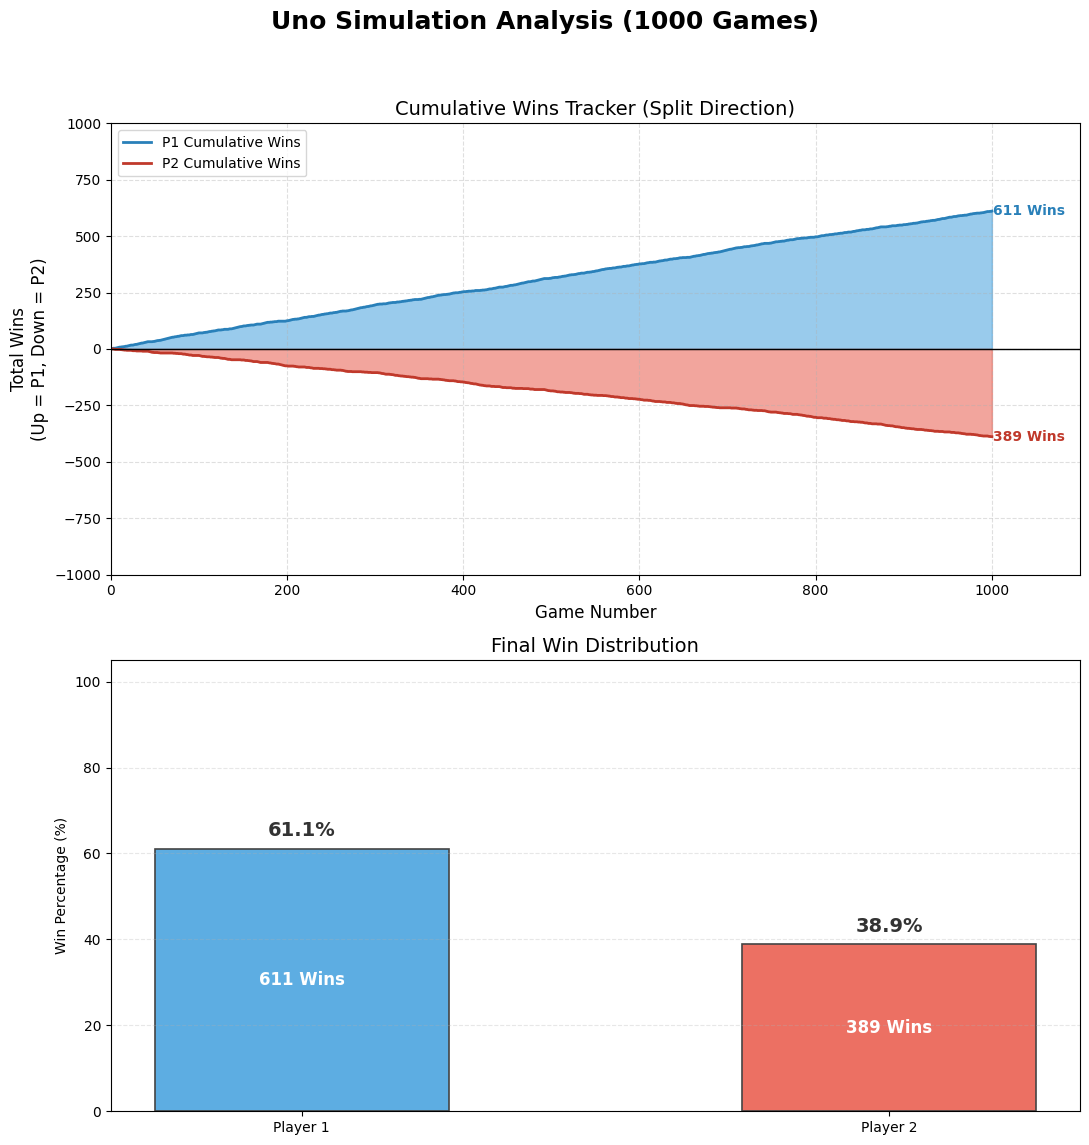

In [ ]:
# AI vs Heuristic
if __name__ == "__main__":
    total_game = 1000
    print("Uno AI vs Heuristic Player Test\n")

    # Create players
    ai_player = Uno_AI(player_id=1, num_samples=500, lookahead=1)
    heuristic_player = Uno_Heuristic(player_id=2)

    # Create game controller
    controller = GameController(ai_player, heuristic_player, verbose=True)

    # Play single game
    print("Playing single game with full output:\n")
    winner_list = []
    for i in range(total_game):
      winner, turns = controller.play_game(seed=i+67)
      winner_list.append(winner)

    print(f"Total Games: {len(winner_list)}")
    print(f"Number of times '1' is the winner: {winner_list.count(1)}; {winner_list.count(1)/total_game * 100}%")
    print(f"Number of times '2' is the winner: {winner_list.count(2)}; {winner_list.count(2)/total_game * 100}%")
    plot_uno_results(winner_list)

Uno AI vs Heuristic Player Test

Playing single game with full output:

Deck empty - reshuffled 71 cards from pile
Deck empty - reshuffled 66 cards from pile
Deck empty - reshuffled 70 cards from pile
Deck empty - reshuffled 69 cards from pile
Deck empty - reshuffled 70 cards from pile
Deck empty - reshuffled 68 cards from pile
Deck empty - reshuffled 64 cards from pile
Deck empty - reshuffled 61 cards from pile
Deck empty - reshuffled 71 cards from pile
Deck empty - reshuffled 63 cards from pile
Deck empty - reshuffled 72 cards from pile
Deck empty - reshuffled 68 cards from pile
Deck empty - reshuffled 72 cards from pile
Total Games: 1000
Number of times '1' is the winner: 503; 50.3%
Number of times '2' is the winner: 497; 49.7%


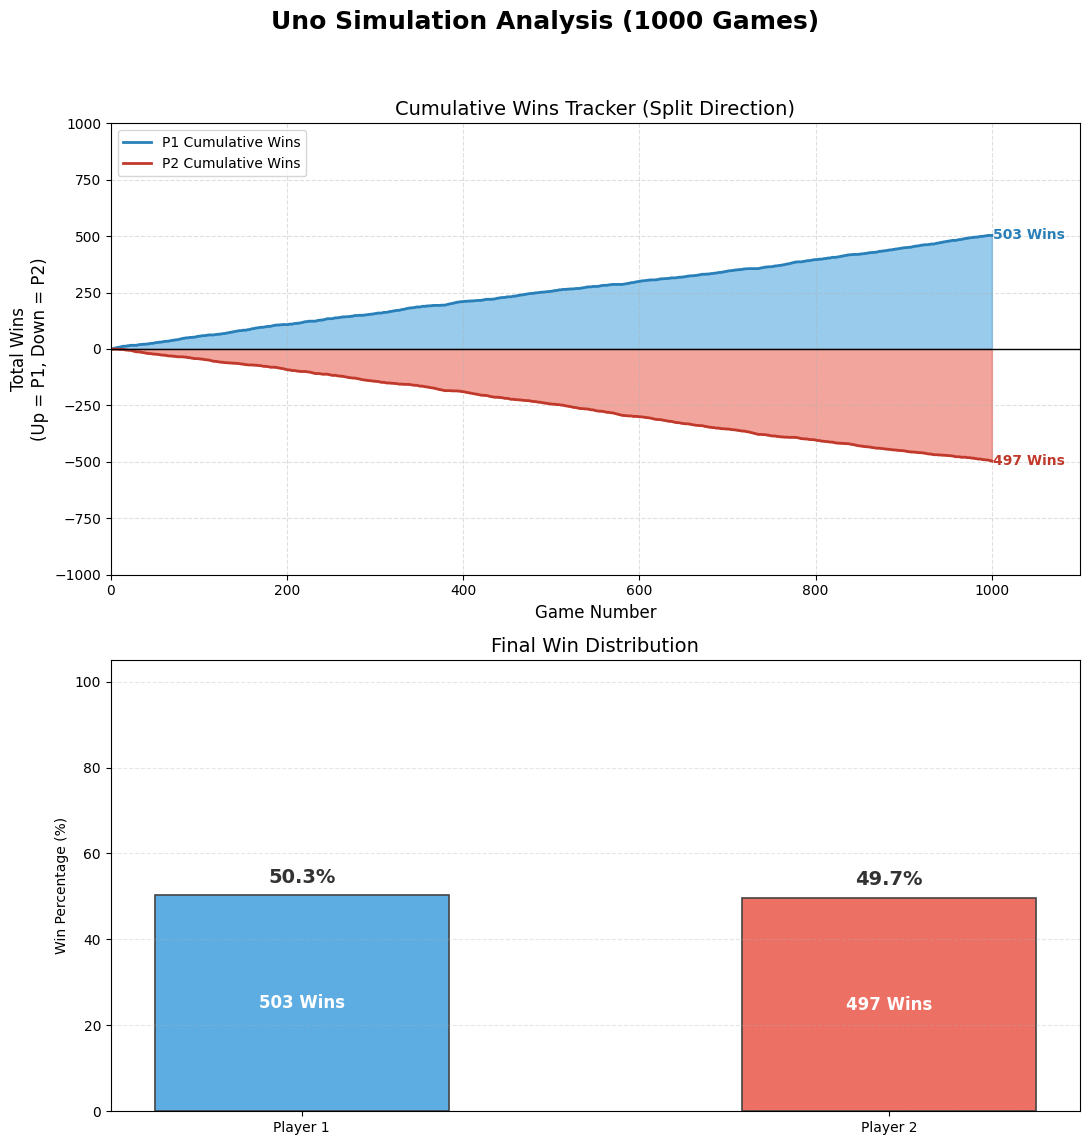

In [ ]:
# Heuristic vs Heuristic Player:

if __name__ == "__main__":
    total_game = 1000
    print("Uno AI vs Heuristic Player Test\n")

    # Create players
    heuristic_player_1 = Uno_Heuristic(player_id=1)
    heuristic_player_2 = Uno_Heuristic(player_id=2)

    # Create game controller
    controller = GameController(heuristic_player_1, heuristic_player_2, verbose=False)

    # Play single game
    print("Playing single game with full output:\n")
    winner_list = []
    for i in range(total_game):
      winner, turns = controller.play_game(seed=i+67)
      winner_list.append(winner)

    print(f"Total Games: {len(winner_list)}")
    print(f"Number of times '1' is the winner: {winner_list.count(1)}; {winner_list.count(1)/total_game * 100}%")
    print(f"Number of times '2' is the winner: {winner_list.count(2)}; {winner_list.count(2)/total_game * 100}%")
    plot_uno_results(winner_list)